In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')

import sys
sys.path.append('../src') 

from scipy.stats import norm
from scipy.optimize import minimize

In [48]:
df_spy = yf.download('spy'.upper(),
                     start=(datetime.today() - relativedelta(years=10)).strftime('%Y-%m-%d'),
                     end=(datetime.today() - relativedelta(days=1)).strftime('%Y-%m-%d'))
df_spy = df_spy.reset_index()
df_spy.columns = df_spy.columns.str.lower()
print(df_spy.shape)
df_spy.head()

[*********************100%%**********************]  1 of 1 completed
(2516, 7)


,date,open,high,low,close,adj close,volume
0,2014-02-18,184.179993,184.490005,183.649994,184.240005,153.770813,80460900
1,2014-02-19,183.759995,184.949997,182.869995,183.020004,152.752655,126524300
2,2014-02-20,183.270004,184.520004,182.600006,184.100006,153.653976,104998100
3,2014-02-21,184.449997,184.889999,183.800003,183.889999,153.478729,118116400
4,2014-02-24,184.279999,186.149994,184.199997,184.910004,154.330017,114063900


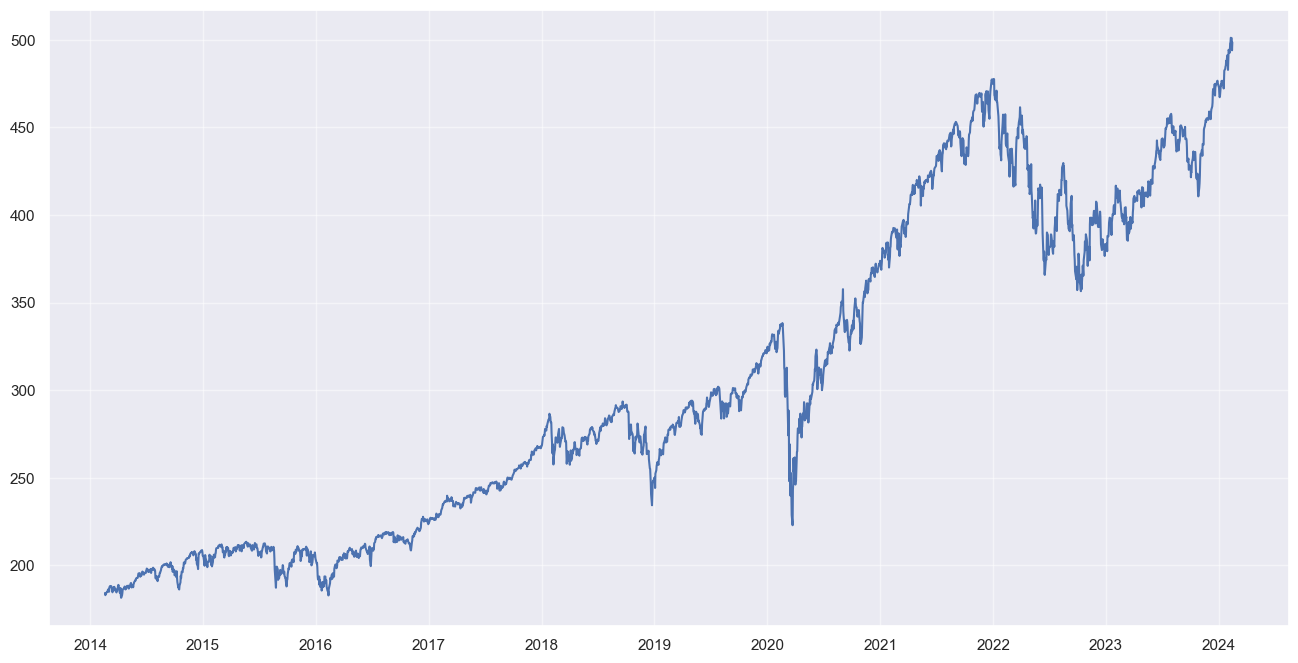

In [49]:
plt.figure(figsize=(16, 8))
plt.grid(True, alpha=0.5)

plt.plot(df_spy['date'], df_spy['close'], label='Daily Close Price')

In [50]:
# Generate synthetic daily stock price data for demonstration
np.random.seed(42)  # for reproducibility
num_days = df_spy.shape[0]  
initial_price = df_spy['close'][0]
drift = 0.05  # initial guess for drift
volatility = 0.2  # initial guess for volatility

# Generate synthetic daily stock price data
def generate_stock_prices(drift, volatility, initial_price, num_days):
    daily_returns = np.exp((drift - 0.5 * volatility**2) + volatility * norm.ppf(np.random.rand(num_days)))
    stock_prices = initial_price * pd.Series(daily_returns.cumprod(), name='Close')
    return stock_prices

# Log-likelihood function for GBM
def gbm_log_likelihood(params, prices):
    mu, sigma = params
    dt = 1  # time increment (1 day)
    returns = np.diff(np.log(prices))
    ll = -len(returns) / 2 * np.log(2 * np.pi) - len(returns) / 2 * np.log(sigma ** 2) - (1 / (2 * sigma ** 2)) * np.sum((returns - (mu - 0.5 * sigma ** 2) * dt) ** 2)
    return -ll

# Fit GBM parameters using MLE
def fit_gbm_params(prices):
    initial_guess = [0.05, 0.2]  # initial guess for drift and volatility
    result = minimize(gbm_log_likelihood, initial_guess, args=(prices,), bounds=((None, None), (0.001, None)))
    mu_mle, sigma_mle = result.x
    return mu_mle, sigma_mle

In [51]:
drift_mle, volatility_mle = fit_gbm_params(df_spy['close'])
print('Drift:', drift_mle)
print('Volatility:', volatility_mle)

Drift: 0.0004579561887733856
Volatility: 0.011112987077973938


In [52]:
estimated_prices = generate_stock_prices(drift_mle, volatility_mle, initial_price, num_days)
estimated_prices

0       183.659037
1       187.135664
2       188.501763
3       189.100844
4       187.062335
           ...    
2511    487.770490
2512    487.259830
2513    487.594619
2514    489.541044
2515    497.686979
Name: Close, Length: 2516, dtype: float64

In [53]:
expectation_return = initial_price*np.exp(drift_mle*np.arange(start=0, stop=num_days))
expectation_return

array([184.24000549, 184.32439867, 184.4088305 , ..., 582.35672395,
       582.62347889, 582.89035602])

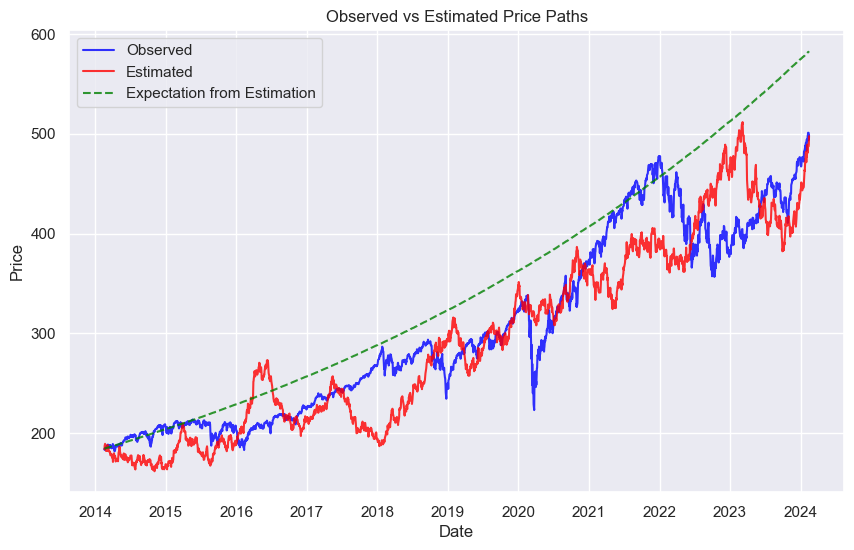

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(df_spy['date'], df_spy['close'], label='Observed', color='blue', alpha=0.8)
plt.plot(df_spy['date'], estimated_prices.values, label='Estimated', color='red', alpha=0.8)
plt.plot(df_spy['date'], expectation_return, label='Expectation from Estimation', color='green',linestyle='--', alpha=0.8)

plt.title('Observed vs Estimated Price Paths')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()